In [1]:
from google.colab import files
uploaded = files.upload()

Saving TESS.zip to TESS.zip


In [2]:
import zipfile
import os
zip_path = "/content/TESS.zip"
extract_path = "/content/TESS"
# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
# List contents
print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['TESS Toronto emotional speech set data', 'tess toronto emotional speech set data']


In [3]:
pip install sounddevice librosa numpy tensorflow

In [5]:
# Audio processing
import os
import librosa
import numpy as np

# Label encoding and data split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout,
                                     Reshape, LSTM, Dense, TimeDistributed, BatchNormalization)
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Define path to the extracted TESS dataset
data_path = "/content/TESS"

# Emotions map (you can customize these if needed)
emotion_map = {
    'angry': 'angry',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'ps': 'pleasant_surprise',
    'sad': 'sad'
}

# Feature and label holders
X = []
y = []

# Loop through all files
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = file.split('_')[-1].replace('.wav', '').lower()

            # Validate emotion
            if emotion in emotion_map:
                # Load audio
                signal, sr = librosa.load(file_path, sr=22050)

                # Extract MFCCs
                mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
                mfccs = np.mean(mfccs.T, axis=0)  # Average across time

                X.append(mfccs)
                y.append(emotion_map[emotion])

print("Total samples:", len(X))
print("Example feature shape:", X[0].shape)
print("Emotions found:", set(y))


Total samples: 5600
Example feature shape: (40,)
Emotions found: {'sad', 'neutral', 'pleasant_surprise', 'happy', 'angry', 'disgust', 'fear'}


In [7]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [8]:
# Encode labels (e.g., 'happy' -> 3, etc.)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [9]:
# One-hot encode labels
y_categorical = to_categorical(y_encoded)

In [10]:
# Reshape input for CRNN: (samples, time_steps, features, channels)
# Since we used mean of MFCCs, we'll reshape to fake 2D form: (samples, 10, 4, 1)
# If you extracted full MFCC matrix earlier, use that shape instead
X = np.array(X) # Convert X to a numpy array
X = X.reshape(X.shape[0], 10, 4, 1)

In [11]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)
print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)
print("Number of emotion classes:", y_categorical.shape[1])

Training samples: (4480, 10, 4, 1)
Testing samples: (1120, 10, 4, 1)
Number of emotion classes: 7


In [12]:
# Define input shape
input_shape = (10, 4, 1)
num_classes = y_categorical.shape[1]

# Build CRNN model
model = Sequential()

# 1. Convolution + Pooling
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# 2. Reshape for RNN (LSTM expects shape: [batch, time_steps, features])
model.add(Reshape((model.output_shape[1], model.output_shape[2] * model.output_shape[3])))

# 3. LSTM Layer
model.add(LSTM(64))
model.add(Dropout(0.3))

# 4. Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 9, 3, 32)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 1, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,575 (99.90 KB)

 Trainable params: 25,511 (99.65 KB)

 Non-trainable params: 64 (256.00 B)

In [13]:
# Train the CRNN model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3334 - loss: 1.7223 - val_accuracy: 0.7741 - val_loss: 0.7612
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7449 - loss: 0.7083 - val_accuracy: 0.9286 - val_loss: 0.2751
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8748 - loss: 0.3810 - val_accuracy: 0.9607 - val_loss: 0.1554
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9087 - loss: 0.2719 - val_accuracy: 0.9688 - val_loss: 0.1001
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9249 - loss: 0.2198 - val_accuracy: 0.9786 - val_loss: 0.0800
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9310 - loss: 0.1955 - val_accuracy: 0.9804 - val_loss: 0.0673
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9404 - loss: 0.1686 - val_accuracy: 0.9696 - val_loss: 0.0739
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9441 - loss: 0.1592 - val_accuracy: 0.

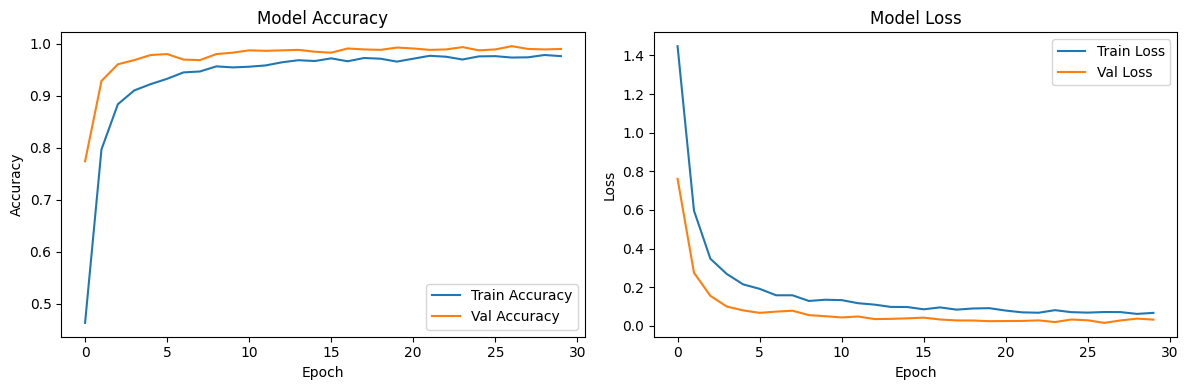

In [14]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


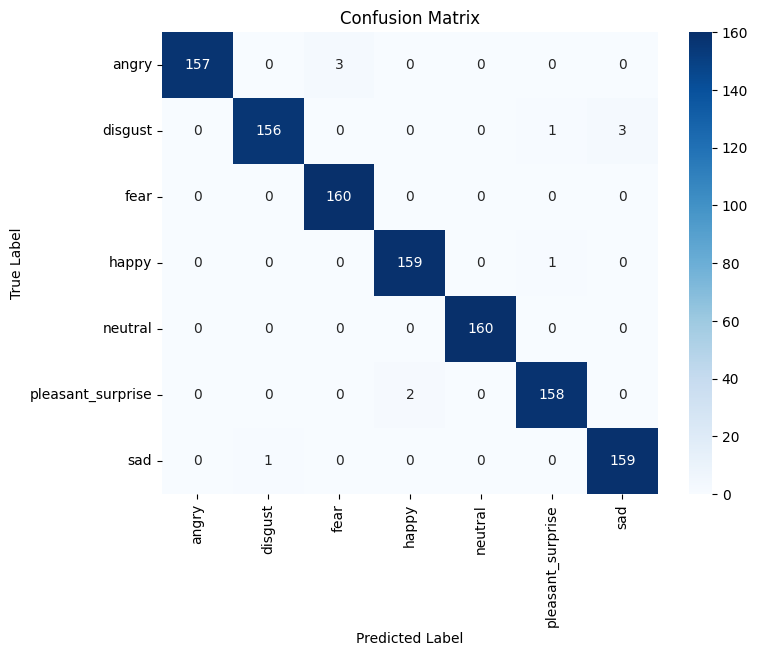


Classification Report:

                   precision    recall  f1-score   support

            angry       1.00      0.98      0.99       160
          disgust       0.99      0.97      0.98       160
             fear       0.98      1.00      0.99       160
            happy       0.99      0.99      0.99       160
          neutral       1.00      1.00      1.00       160
pleasant_surprise       0.99      0.99      0.99       160
              sad       0.98      0.99      0.99       160

         accuracy                           0.99      1120
        macro avg       0.99      0.99      0.99      1120
     weighted avg       0.99      0.99      0.99      1120



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict probabilities → then take the class with highest probability
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels
class_labels = label_encoder.classes_

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


In [16]:
# 1️⃣ Evaluate on Train Set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"✅ Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"❗ Train Loss: {train_loss:.4f}")
# 2️⃣ Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"❗ Test Loss: {test_loss:.4f}")

✅ Train Accuracy: 99.58%
❗ Train Loss: 0.0140
✅ Test Accuracy: 99.02%
❗ Test Loss: 0.0324


In [17]:
# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Decode emotion labels
predicted_emotions = label_encoder.inverse_transform(y_pred)
true_emotions = label_encoder.inverse_transform(y_true)

# Show some predictions
for i in range(10):
    print(f"True: {true_emotions[i]}  →  Predicted: {predicted_emotions[i]}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
True: neutral  →  Predicted: neutral
True: disgust  →  Predicted: disgust
True: sad  →  Predicted: sad
True: disgust  →  Predicted: disgust
True: sad  →  Predicted: sad
True: pleasant_surprise  →  Predicted: pleasant_surprise
True: disgust  →  Predicted: disgust
True: sad  →  Predicted: sad
True: disgust  →  Predicted: disgust
True: pleasant_surprise  →  Predicted: pleasant_surprise


In [18]:
model.save("speech_emotion_crnn_model.keras")

In [28]:
# Upload audio file
from google.colab import files
uploaded = files.upload()
file_path = list(uploaded.keys())[0]  # Get uploaded file name

# Import libs
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load trained model
model = tf.keras.models.load_model("speech_emotion_crnn_model.keras")  # use .h5 if you saved it that way

# Load label encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad'])  # same as during training

# Predict function
def predict_emotion(file_path):
    signal, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)
    X_input = mfccs.reshape(1, 10, 4, 1)
    pred = model.predict(X_input)
    emotion = label_encoder.inverse_transform([np.argmax(pred)])
    return emotion[0]

# Run prediction
emotion = predict_emotion(file_path)
print("🎭 Predicted Emotion:", emotion)


Saving OAF_bath_sad.wav to OAF_bath_sad.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
🎭 Predicted Emotion: sad


In [22]:
import gradio as gr
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load your trained model
model = tf.keras.models.load_model("speech_emotion_crnn_model.keras")

# Label encoder (same order used in training)
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad'])
# Prediction function
def predict_emotion(audio):
    # 'audio' is a tuple: (sample_rate, data)
    if audio is None:
        return "No audio uploaded."
    sr, signal = audio
    signal = np.array(signal)

    # Feature extraction
    mfccs = librosa.feature.mfcc(y=signal.astype(float), sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    X_input = mfccs_mean.reshape(1, 10, 4, 1)

    # Prediction
    pred = model.predict(X_input)
    emotion = label_encoder.inverse_transform([np.argmax(pred)])
    return f"🎭 Emotion: {emotion[0]}"
# Gradio interface
gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(type="numpy", label="📁 Upload a .wav file"),
    outputs=gr.Textbox(label="Predicted Emotion"),
    title="🎤 Speech Emotion Recognition",
    description="Upload a .wav file to detect emotion in speech",
    allow_flagging="never"
).launch(share=True)





Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://18f9053385030b7cf5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [25]:
code = '''
import gradio as gr
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load your trained model
model = tf.keras.models.load_model("speech_emotion_crnn_model.keras")

# Label encoder (same order used in training)
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad'])

# Prediction function
def predict_emotion(audio):
    if audio is None:
        return "No audio uploaded."
    sr, signal = audio
    signal = np.array(signal)

    mfccs = librosa.feature.mfcc(y=signal.astype(float), sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    X_input = mfccs_mean.reshape(1, 10, 4, 1)

    pred = model.predict(X_input)
    emotion = label_encoder.inverse_transform([np.argmax(pred)])
    return f"🎭 Emotion: {emotion[0]}"

# Gradio interface
gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(type="numpy", label="📁 Upload a .wav file"),
    outputs=gr.Textbox(label="Predicted Emotion"),
    title="🎤 Speech Emotion Recognition",
    description="Upload a .wav file to detect emotion in speech",
    allow_flagging="never"
).launch(share=True)
'''

# Save to a file
with open("gradio_emotion_app.py", "w") as f:
    f.write(code)

